# Plot network location map based on ASDF database

In [4]:
import os
import sys
import datetime

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
package_root = os.path.abspath(os.path.abspath('../../..'))
if package_root not in sys.path:
    sys.path.append(package_root)
from seismic.ASDFdatabase import FederatedASDFDataSet
from seismic.xcorqc.analytic_plot_utils import drawBBox
import obspy

In [7]:
from mpl_toolkits.basemap import Basemap
# from descartes import PolygonPatch
# from shapely.geometry import Polygon

In [8]:
ds = FederatedASDFDataSet.FederatedASDFDataSet("/g/data/ha3/Passive/SHARED_DATA/Index/asdf_files.txt")

Found database: /g/data/ha3/Passive/SHARED_DATA/Index/c120284bcf4931e639eecf4e026f6ccfaf7b6306.db


In [9]:
def get_network_stations(df, netcode):
    """
    Get the unique station codes belonging to a given network from a Pandas DataFrame

    :param df: Pandas dataframe
    :type df: pandas.DataFrame
    :param netcode: Network code for which station codes will be returned
    :type netcode: str
    :return: Sorted list of station code strings extracted from df
    :rtype: list(str)
    """
    return sorted(df[df['net'] == netcode]['sta'].unique().tolist())

In [10]:
# def get_network_date_range(df, netcode):
#     """
#     Get the date range of records in df for a given network code

#     :param df: Pandas dataframe
#     :type df: pandas.DataFrame
#     :param netcode: Network code whose pick event dates min and max will be returned
#     :type netcode: str
#     :return: Min and max dates of picks for given network
#     :rtype: tuple(obspy.UTCDateTime, obspy.UTCDateTime)
#     """
#     mask = (df['net'] == netcode)
#     df_net = df.loc[mask]
#     min_date = df_net['start_time'].min()
#     max_date = df_net['end_time'].max()
#     return (obspy.UTCDateTime(min_date), obspy.UTCDateTime(max_date))

In [12]:
# Some select stations require custom date filters to remove events outside
# the known valid date range of a network. Filter out network codes from earlier
# periods which are not of interest.
def applyCustomerDateFilter(df):
    DATE_FILTER = (
        ('7D', pd.Timestamp(datetime.datetime(2010, 1, 1))),
        ('7G', pd.Timestamp(datetime.datetime(2010, 1, 1))),
    )
    before = len(df)
    for net, min_date in DATE_FILTER:
        date_mask = (df['net'] == net) & (df['start_time'] < min_date.timestamp())
        df = df[~date_mask]
    after = len(df)
    print('Removed {} events due to known invalid timestamps'.format(before - after))
    return df

In [13]:
# Get all nets and stations
all_codes = [x for x in ds.local_net_sta_list()]

In [14]:
df_asdf = pd.DataFrame(np.array(all_codes), columns=['net', 'sta', 'start_time', 'end_time'])
df_asdf[0:5]

,net,sta,start_time,end_time
0,HK,HKPS,2011-05-27T00:00:00.000000Z,2017-12-31T23:59:59.000000Z
1,OA,CA28,2017-09-17T00:54:06.000000Z,2018-11-22T23:09:12.000000Z
2,OA,CA22,2017-09-21T00:43:13.000000Z,2018-11-21T21:59:10.000000Z
3,OA,CA23,2017-09-19T03:41:03.000000Z,2018-11-21T21:23:45.000000Z
4,OA,CA20,2017-10-04T00:15:04.000000Z,2018-11-17T22:27:36.000000Z


In [15]:
df_asdf = applyCustomerDateFilter(df_asdf)

Removed 32 events due to known invalid timestamps


In [16]:
# 7* network deployments
temp_deploys = sorted([n for n in df_asdf['net'].unique() if n[0] == '7'])
temp_deploys

[u'7B', u'7D', u'7E', u'7F', u'7G', u'7J', u'7W', u'7X']

In [17]:
sta_coords = ds.unique_coordinates
lat_lon = []
for _, row in df_asdf.iterrows():
    code = ".".join([row['net'], row['sta']])
    lat_lon.append(sta_coords[code])

df_asdf['latitude'] = np.array(lat_lon)[:,1]
df_asdf['longitude'] = np.array(lat_lon)[:,0]
df_asdf[0:5]

,net,sta,start_time,end_time,latitude,longitude
0,HK,HKPS,2011-05-27T00:00:00.000000Z,2017-12-31T23:59:59.000000Z,22.277600,114.141500
1,OA,CA28,2017-09-17T00:54:06.000000Z,2018-11-22T23:09:12.000000Z,-21.502054,136.992310
2,OA,CA22,2017-09-21T00:43:13.000000Z,2018-11-21T21:59:10.000000Z,-18.497307,136.995956
3,OA,CA23,2017-09-19T03:41:03.000000Z,2018-11-21T21:23:45.000000Z,-19.000677,136.991592
4,OA,CA20,2017-10-04T00:15:04.000000Z,2018-11-17T22:27:36.000000Z,-17.510689,136.998932


In [19]:
# stations = get_network_stations(df_asdf, temp_deploys[0])

In [20]:
# get_network_date_range(df_asdf, temp_deploys[0])

In [59]:
def plot_basemap_stations(dest_map, labels, lat, lon, size=50, color='g'):
    sc_handle = dest_map.scatter(lon, lat, size, latlon=True, marker='v', c=color, edgecolor='none')
    for i, label in enumerate(labels):
        plt.annotate(label, xy=dest_map(lon[i] + 0.02, lat[i] - 0.1), fontsize=10)
    return sc_handle

In [67]:
def plot_basemap_networks(df, label_stations=True, title=None, show_inset=True, show_legend=True):

    # AU lat/lon range
    au_min_lat, au_max_lat = -40, -10
    au_min_lon, au_max_lon = 110, 155
    
    min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
    min_lon, max_lon = df['longitude'].min(), df['longitude'].max()
    assert min_lat >= au_min_lat
    assert min_lon >= au_min_lon
    assert max_lat <= au_max_lat
    assert max_lon <= au_max_lon

    # Plot stations of network
    fig = plt.figure(figsize=(12, 12))

    latlon_margin = max(0.8, max((max_lat - min_lat)/10, (max_lon - min_lon)/10))
    m = Basemap(llcrnrlon=min_lon - latlon_margin, llcrnrlat=min_lat - latlon_margin,
                urcrnrlon=max_lon + latlon_margin, urcrnrlat=max_lat + latlon_margin,
                projection='lcc', resolution='i',
                lat_1=min_lat, lat_2=max_lat,
                lat_0=(min_lat + max_lat) * 0.5, lon_0=(min_lon + max_lon) * 0.5)

    m.drawcoastlines(color='#a0a0a0', linewidth=2)
    state_border_color = "#9090ff"
    m.drawstates(color=state_border_color, linewidth=2)

    #draw grid
    parallels = np.linspace(np.floor(min_lat) - 5, np.ceil(max_lat) + 5, \
                            int((np.ceil(max_lat) + 5) - (np.floor(min_lat) - 5)) + 1)
    m.drawparallels(parallels, labels=[True, True, False, False], color="#a0a0a0")
    meridians = np.linspace(np.floor(min_lon) - 5, np.ceil(max_lon) + 5, \
                            int((np.ceil(max_lon) + 5) - (np.floor(min_lon) - 5)) + 1)
    m.drawmeridians(meridians, labels=[False, False, True, True], rotation=45, color="#a0a0a0")

    # plot stations
    color_index = 0
    legend_labels = []
    handles = []
    for net, df_net in df.groupby('net'):
        colcode = "C{}".format(color_index)
        legend_labels.append(net)
        if label_stations:
            labels = df_net['sta'].values
        else:
            labels = []
        sc_h = plot_basemap_stations(m, labels, df_net['latitude'].values, 
                                     df_net['longitude'].values, color=colcode)
        handles.append(sc_h)
        color_index = (color_index + 1) % 10
    if show_legend:
        plt.legend(handles, legend_labels, title='Network code')

    if title is not None:
        plt.title(title, fontsize = 18, y=1.05)

    # Draw inset of entire continent
    if show_inset:
        inset_ax = fig.add_axes([0.75, 0.77, 0.100, 0.100])
        inset = Basemap(resolution='c', ax=inset_ax, projection='merc',
                        lat_0=-20, lon_0=132,
                        llcrnrlon=au_min_lon, llcrnrlat=au_min_lat,
                        urcrnrlon=au_max_lon, urcrnrlat=au_max_lat)
        inset.fillcontinents(color='lightgray')
        inset.drawstates(color=state_border_color)
        drawBBox(min_lon, min_lat, max_lon, max_lat, inset, fill='True', facecolor='#40404080',
                 linestyle=':', edgecolor='#404040')

In [49]:
TARGET_NETS = {'net': [u'7B', u'7D', u'7E', u'7F', u'7G', u'7J', u'7W', u'7X']}

In [51]:
# for target_net in TARGET_NETS['net']:
#     plot_basemap_networks(df_asdf.loc[df_asdf['net'] == target_net], 
#                           title="Deployment Name: {}".format(target_net))
#     plt.show()

In [38]:
target_mask = df_asdf[list(TARGET_NETS)].isin(TARGET_NETS).all(axis=1)
df_target = df_asdf.loc[target_mask]

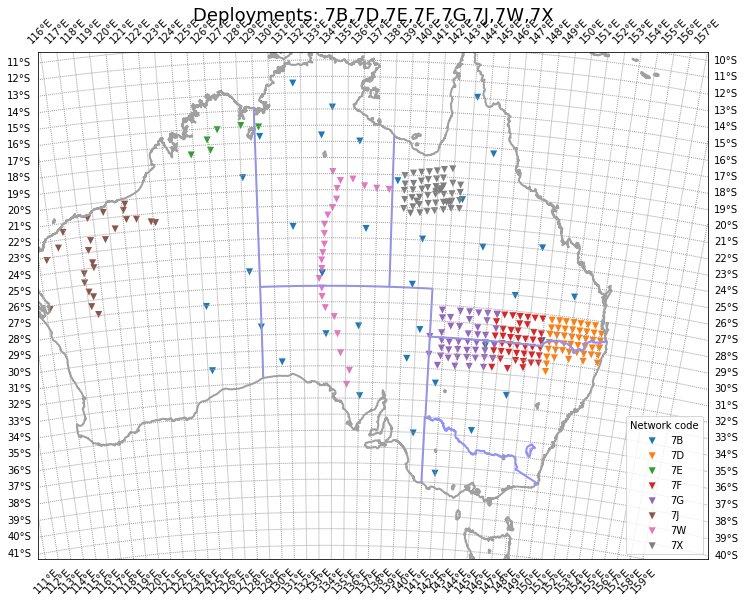

In [68]:
title = "Deployments: {}".format(','.join(TARGET_NETS['net']))
plot_basemap_networks(df_target, title=title, show_inset=False, 
                      label_stations=False)